# TODO
Specif Sensiti - trafnosci w poszczegolnych klasach naczynia tło, Prec - ... miary
porównanie sato z machine learning


# Segmenting Retinal Blood Vessels With Deep Neural Networks


In [1]:
import skimage as ski
from skimage import io, exposure, data, color, data, filters, graph, measure, morphology
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from PIL import Image
from scipy import ndimage as ndi
from imblearn.metrics import classification_report_imbalanced

from image_processing import *
from functions import *

filename = 'Data/01_dr.jpg'
mask_filename = 'Data/01_dr_mask.tif'
manual_filename = 'Data/01_dr.tif'

image = loadImage(filename)
mask = loadImageTif(mask_filename)
manual = loadImageTif(manual_filename)

# Sato filter

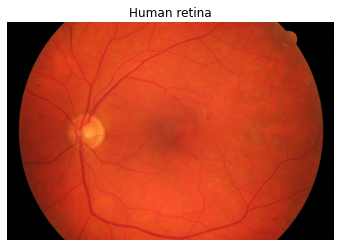

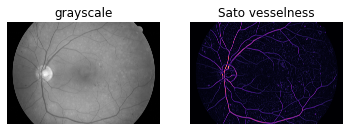

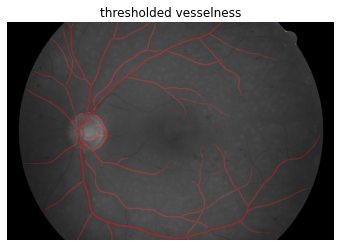

In [18]:
_, ax = plt.subplots()
ax.imshow(image)
ax.set_axis_off()
_ = ax.set_title('Human retina')

retina = color.rgb2gray(image)
t0, t1 = filters.threshold_multiotsu(retina, classes=3)
mask = (retina > t0)
vessels = filters.sato(retina, sigmas=range(1, 10)) * mask

_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(retina, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('grayscale')
axes[1].imshow(vessels, cmap='magma')
axes[1].set_axis_off()
_ = axes[1].set_title('Sato vesselness')

thresholded = filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)	#dont override vessels
labeled = ndi.label(thresholded)[0]

_, ax = plt.subplots()
ax.imshow(color.label2rgb(labeled, retina))
ax.set_axis_off()
_ = ax.set_title('thresholded vesselness')


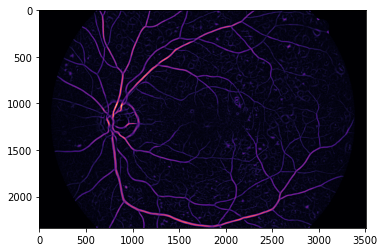

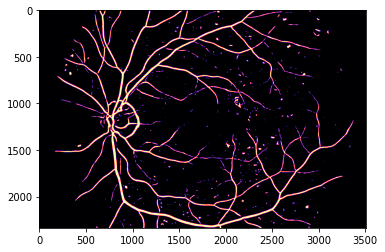

In [19]:
vessels = extract_vessels(image)
showImage(vessels, cmap='magma')
vessels = contrast(vessels)
vessels = threshold(vessels)
showImage(vessels, cmap='magma')

# Comparing vessels 

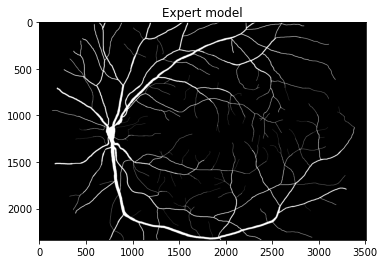

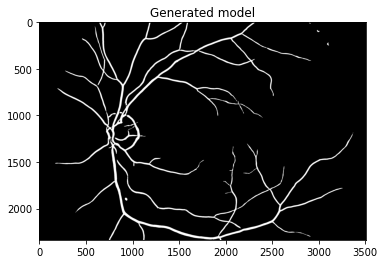

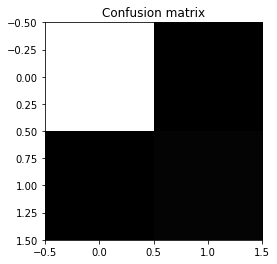

[7644494  124568  147443  268839]

Main metrics:
Accuracy score:		 0.966769
Sensitivity score:	 0.645810
Specificity score:	 0.983966
Precision score:	 0.683361
G-mean: 		 0.797154
Weighted average: 	 0.814888

Classification report with sklearn.metrics
              precision    recall  f1-score   support

  background       0.98      0.98      0.98   7769062
     vessels       0.68      0.65      0.66    416282

    accuracy                           0.97   8185344
   macro avg       0.83      0.81      0.82   8185344
weighted avg       0.97      0.97      0.97   8185344


Classification report with imblearn.metrics
                   pre       rec       spe        f1       geo       iba       sup

 background       0.98      0.98      0.65      0.98      0.80      0.66   7769062
    vessels       0.68      0.65      0.98      0.66      0.80      0.61    416282

avg / total       0.97      0.97      0.66      0.97      0.80      0.65   8185344



In [ ]:
y_pred = vessels.flatten()		# True - żyły, False - tło
y_true = manual.flatten()		# 255 - żyły, 0 - tło
model_mask = (y_true > 0)		# maska pikseli, które reprezentują żyły w modelu ekspertskim

y_true_masked = np.zeros(y_true.shape, dtype=bool)		# utworzenie maski True/False dla modelu ekspertskiego
y_true_masked[model_mask] = True

accuracy = accuracy_score(y_true_masked.flatten(), y_pred.flatten())				# trafność - accuracy
sensitivity = recall_score(y_true_masked.flatten(), y_pred.flatten()) 				# czułość - sensitivity, recall
specificity = recall_score(y_true_masked.flatten(), y_pred.flatten(), pos_label=0)	# swoistość - specificity
precision = precision_score(y_true_masked.flatten(), y_pred.flatten()) 				# precyzja - precision

showImage(y_true_masked.reshape(vessels.shape), title="Expert model")
showImage(y_pred.reshape(vessels.shape), title="Generated model")
showImage(metrics.confusion_matrix(y_true_masked.flatten(), y_pred.flatten()), title="Confusion matrix")
print(metrics.confusion_matrix(y_true_masked.flatten(), y_pred.flatten()).flatten(), end="\n\n")

print("Main metrics:")
print(f"Accuracy score:\t\t {accuracy:.6f}")
print(f"Sensitivity score:\t {sensitivity:.6f}")
print(f"Specificity score:\t {specificity:.6f}")
print(f"Precision score:\t {precision:.6f}")
print("G-mean: \t\t", round(np.sqrt(sensitivity * specificity), 6))
print("Weighted average: \t", round((sensitivity + specificity) / 2, 6))

print("\nClassification report with sklearn.metrics")
print(classification_report(y_true_masked.flatten(), y_pred.flatten(), target_names=["background", "vessels"]))
print("\nClassification report with imblearn.metrics")
print(classification_report_imbalanced(y_true_masked, y_pred, target_names=['background', 'vessels']))

# tn, fp, fn, tp = confusion_matrix(y_true_masked, y_pred).ravel()
# specificity = tn / (tn+fp)												# daje ten sam rezultat co recall_score(y_true_masked, y_pred, pos_label=0)
# y_pred_masked = np.zeros(y_pred.shape, dtype=bool)
# y_pred_masked[model_mask] = (y_pred[model_mask] > 0)
# showImage(y_pred_masked.reshape(vessels.shape))

In [163]:
both_vessels = np.logical_and(vessels, manual)
wrong_vessels = np.logical_xor(vessels, manual)
all_vessels = np.logical_or(vessels, manual)
print("Sensitivity:" , round(sum(both_vessels.flatten() + sum(wrong_vessels.flatten())) / sum(all_vessels.flatten())*100, 3), "%")

<ipython-input-163-5da2418774eb>:4: RuntimeWarning: overflow encountered in scalar add
  print("Sensitivity:" , round(sum(both_vessels.flatten() + sum(wrong_vessels.flatten())) / sum(all_vessels.flatten())*100, 3), "%")


Sensitivity: -12086.966 %


In [164]:
y_true = manual.flatten()
y_pred = vessels.flatten()

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9208949556671046


# REST

## Frangi's filter

In [ ]:
# filtr frangi
def frangi(image):
	image = ski.filters.frangi(image, black_ridges=True)
	return image

## Frangi's filter, doesn't work

Original image


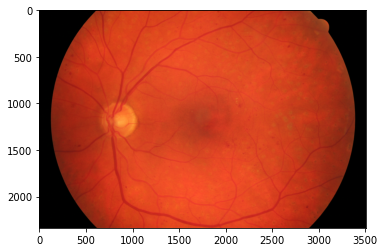

Extract green channel


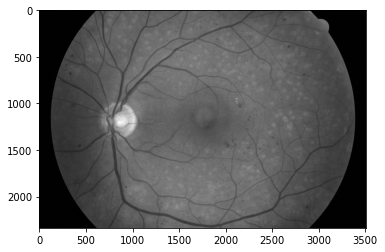

mask


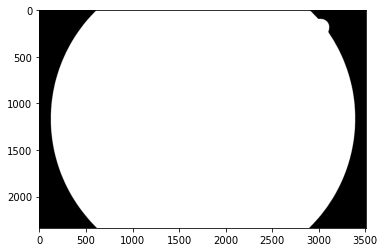

image with mask


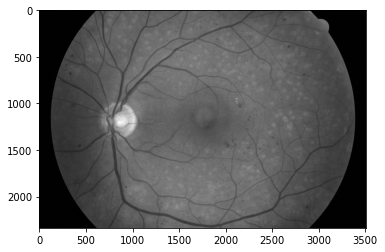

Frangi`s filter


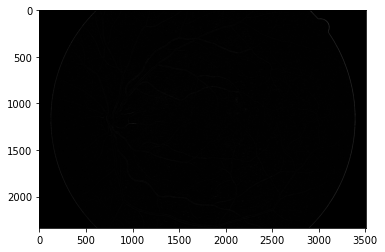

In [ ]:
image = loadImage(filename)
mask = loadImageTif(mask_filename)
print("Original image")
showImage(image)

sharpen_img = True
bright_img = True
contrast_img = True

# print("Edited image")
# if sharpen_img:
# 	image = sharpen(image)
# if bright_img:
# 	image = brightness(image)
# if contrast_img:
# 	image = contrast(image)
# showImage(image)

print("Extract green channel")
image = extract_green_channel(image)
showImage(image)

print("mask")
mask = mask[:, :, 0]
showImage(mask)

print("image with mask")
img = image * mask
showImage(image)
# for i in range(100,600,10):
# 	print(img[500][i])

print("Frangi`s filter")
for i in range(len(img)):
	average = np.average(img[i])
	for j in range(len(img[i])):
		if img[i][j] == 0:
			img[i][j] = average

image = frangi(img)
image = brightness(image)
#image = frangi(image)
showImage(image)
